<a href="https://colab.research.google.com/github/zoebatz/CAP6640_Project/blob/main/NLP_gpt_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import openai
import pandas as pd
import numpy as np
import os
import kagglehub

from google.colab import userdata

# print(openai.__version__)
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_NLP')

In [64]:
# import data from google drive
file_name = "data_sa1"

path = "/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/data/"+file_name+".csv"
data = pd.read_csv(path)
data.head()



,text,sentiment,label
0,Social justice requires addressing systemic in...,positive,1
1,Racial discrimination in policing and criminal...,negative,0
2,Equal access to education is essential for bre...,positive,1
3,Gender-based violence and discrimination are p...,negative,0
4,"Immigrant rights are human rights, and policie...",positive,1


In [65]:
len(data)

100

In [66]:
data.value_counts('label')

,count
label,
1,66
0,34


In [67]:
zero_shot = f""" """

one_shot = f"""
              Input: "This is the best concert ever!"
              Output: Positive
              Input: "I wish I could give this product zero stars!"
              Output: Negative
"""

three_shot = f"""
            Input: "Today is a great day"
            Output: Postive
            Input: "My dinner was cold when the server finally brought it out."
            Output: Negative
            Input: "I got an A on my paper."
            Output: Positive
            Input: "It's been raining for a week, I miss the sun."
            Output: Negative
            Input: "Everything I needed at the store was on sale."
            Ouput: Positive
            Input: "My rent keeps going up."
            Output: Negative
"""


In [68]:
# sentiment analysis with GPT

def classify_sentiment(text, shot):
    try:
        # Call GPT-3.5 Turbo
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a sentiment analysis assistant. Classify the sentiment of the given text as Positive or Negative. Do not include any extra words or explanations. Only return 'Positive' or 'Negative'."},
                {"role": "user", "content": shot},
                {"role": "user", "content": text}
            ]
        )
        # Extract and return the response
        sentiment = response.choices[0].message.content.strip()
#       print(response.choices[0].message.content)
        return sentiment
    except Exception as e:
        return f"Error: {e}"


In [80]:
# adjust for desired prompt / model / data size
test_size = len(data)   # can adjust for smaller testing

function = classify_sentiment
shot_name = "three_shot"      # change for zero / one / three shot
model_name = "gpt-3.5-turbo"  # change for different models


In [81]:

prediction = []

if shot_name == "one_shot":
  shot = one_shot
elif shot_name == "three_shot":
  shot = three_shot
else:
  shot = zero_shot

# sentiment analysis
def sentiment_analysis(data):
  count = 0
  for i, texts in enumerate(data.text[:test_size]):
    result = function(texts, shot)
    count += 1
    if count % 10 == 0:
      print(count)

#    print("\nresult: ", result)
#    print("label: ", data.label[i])

#    print(data.text[i])

    if result == 'Positive':
      prediction.append(1)

    elif result == 'Negative':
      prediction.append(0)

    else:
      # Handle unexpected results by appending a default value
      print(f"Unexpected result for text at index {i}: {result}")
      prediction.append(2) # Append 2 as a default for unexpected results



In [82]:
#text_classification(data)
sentiment_analysis(data)

10
20
30
40
Unexpected result for text at index 39: Neutral
50
60
70
80
90
100


In [83]:
prediction.count(2) # catch any unexpected results

1

In [84]:
len(prediction)

100

In [86]:
# set prediction = 2 to 0
for i in range(len(prediction)):
  if prediction[i] == 2:
    prediction[i] = 0

In [87]:
file_name

'data_sa1'

In [88]:
shot_name


'three_shot'

In [89]:
# view metrics and save
def view_and_save_metrics(data, predicted_classes):
  accuracy = accuracy_score(data.tolist(), predicted_classes)
  precision = precision_score(data.tolist(), predicted_classes)
  recall = recall_score(data.tolist(), predicted_classes)
  f1 = f1_score(data.tolist(), predicted_classes)
  conf_matrix = confusion_matrix(data.tolist(), predicted_classes)
  #roc_auc = roc_auc_score(data.tolist(), predicted_classes)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("Confusion Matrix:\n", conf_matrix)
  #print("ROC AUC Score:", roc_auc)

  metrics = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1_score": f1,
      "confusion_matrix": conf_matrix,
  #    "roc_auc_score": roc_auc,
      "model_name": model_name,
      "dataset": file_name
  }

  # save metrics to csv file
  metrics_df = pd.DataFrame([metrics])
  metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/sentiment_analysis/metrics_'+model_name+'_'+file_name+'_'+shot_name+'.csv', index=False)

In [90]:
view_and_save_metrics(data.label, prediction)

Accuracy: 0.92
Precision: 0.9264705882352942
Recall: 0.9545454545454546
F1 Score: 0.9402985074626866
Confusion Matrix:
 [[29  5]
 [ 3 63]]


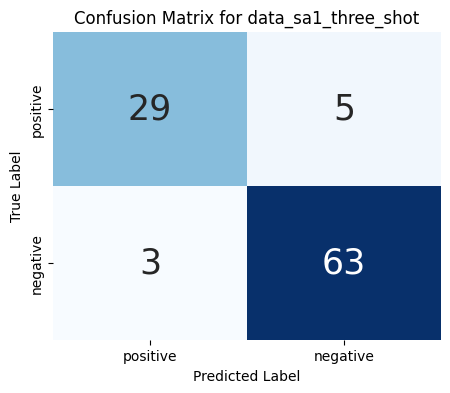

In [91]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data.label, prediction)

# Define class labels
labels = ["positive", "negative"]

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 25}, xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for "+file_name+'_'+shot_name)
# save confusion matrix to drive
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/sentiment_analysis/confusion_matrix_'+model_name+'_'+file_name+'_'+shot_name+'.png')
plt.show()